# Spotify Song Prediction Project
Project mentor: Sophia Sklaviadis

Benjamin Fry <bfry2@jh.edu>, Cassie Parent <cparent5@jh.edu>, Alexandra Szewc <aszewc1@jh.edu>

Link to Project Repo: https://github.com/benf549/CS475-Machine-Learning-Final-Project

In [1]:
import json, torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.sparse import csr_matrix

In [2]:
# Read in the JSON data
data_stream = ""
with open("challenge_set.json", "r") as f:
    data_stream = f.read()
data_set = json.loads(data_stream)


# Grab unique track/artist pairs
track_uris = set()
playlist_idcs = []

for i,j in enumerate(data_set["playlists"]):
    if len(j["tracks"]) == 100:
        playlist_idcs.append(i) 
        for track in j["tracks"]:
            track_uris.add((track["track_name"], track["artist_name"], track["track_uri"]))
unique_tracks = list(track_uris)

# Define mapping between URIs and trakcs
uri_to_title_artist_map = {x[2]: (x[0], x[1]) for x in unique_tracks}
for i,(j,k) in enumerate(uri_to_title_artist_map.items()):
    if i > 20: break
    print(j,k)

spotify:track:4QhjRiHnPswtI1WnnKMXea ('Dirty Nursery Rhymes', '2 LIVE CREW')
spotify:track:0LN5gIsS5tQSmRzQrHSaTR ('Eminence Front', 'The Who')
spotify:track:7sG2bWi2eDtvX9vX8yC1Gn ('Inside Out', 'The Chainsmokers')
spotify:track:2QqaJDUOppTtjJLhTMNN5R ('Dive', 'Coast Modern')
spotify:track:6M6M62TeucVbd5mWHcCZY0 ('Save the Cobra', 'The White Panda')
spotify:track:6dXhOEdzPiD6OulakBdM8b ('5050 (feat. Fiji & Tenelle)', 'Drew Deezy')
spotify:track:5wHNRDvNDTvAvNUllq5v7R ('Little Sister', 'Queens of the Stone Age')
spotify:track:3bsRl34Jfx7WslmIL4JbrG ('More', 'Lecrae')
spotify:track:0jllH0usRFD4LJkJnGK9Lf ('Complicated', "Olivia O'Brien")
spotify:track:2UroOeMz5RT0ifqtHuQQ2k ('No Qualms', 'Karma Kid')
spotify:track:6OfU2HE4cz5EjqcUMDwJsp ('Morras De Acción', 'Banda Los Recoditos')
spotify:track:4lCUTC1Saufwz7RlDN2ldu ('Bloom - Lane 8 Remix', 'ODESZA')
spotify:track:6LUGvXEAK8WxIBYK43uoTb ('Back To The Old House - 2011 Remastered Version', 'The Smiths')
spotify:track:5OR8Eo7uFDTNq1F6E4Jxp

In [3]:
# Rearranging data table
df = pd.read_csv("all_downloaded_data.csv")
df = df.drop("Unnamed: 0", axis=1)
df = df.set_index('uri')
# df = df.iloc[:, :11]
df = df.drop_duplicates()

print(df.head())

                                      danceability  energy  key  loudness  \
uri                                                                         
spotify:track:38uqMByifM0mkjcTbejlyR         0.375   0.294    8    -8.751   
spotify:track:4kOTDj4SiZPkW1p96WMDNv         0.950   0.803    1    -4.195   
spotify:track:1c9LBfX0klXJscJAYDI0Ea         0.758   0.501    0    -7.051   
spotify:track:59iNA6gwthoTJ6IgpBGGHW         0.534   0.749    6    -5.562   
spotify:track:4QCng4MDyUhEZ730Ma2Rjp         0.674   0.744   11    -5.196   

                                      mode  speechiness  acousticness  \
uri                                                                     
spotify:track:38uqMByifM0mkjcTbejlyR     1       0.0329        0.9280   
spotify:track:4kOTDj4SiZPkW1p96WMDNv     1       0.1510        0.1450   
spotify:track:1c9LBfX0klXJscJAYDI0Ea     1       0.0589        0.2520   
spotify:track:59iNA6gwthoTJ6IgpBGGHW     0       0.0749        0.0776   
spotify:track:4QCng4MD

Example of uri_to_title_artist_map usage and characterize dataset

In [4]:
# Validate map use
uri_to_title_artist_map["spotify:track:38uqMByifM0mkjcTbejlyR"]

# Demonstrate data size
print(len(unique_tracks))
print(len(playlist_idcs), "total playlists")
print(df.shape[0], "total songs")

53552
2000 total playlists
53550 total songs


Defining playlist membership relationships for tracks

In [5]:
membership_mtx = np.load("playlist_membership_data.npy")
membership_lbls = np.load("playlist_membership_labels.npy")
print("Avg song is in", np.mean(np.sum(membership_mtx, axis=1)), "playlists")

# Remove mostercat songs that don't exist.
filtered_mtx = membership_mtx
filtered_lbls = membership_lbls
for idx, i in enumerate(filtered_lbls):
    if i[2] == "spotify:track:5CmMyiq4um2aFhiLZ1rPWo":
        filtered_mtx = np.delete(filtered_mtx, idx, axis=0)
        filtered_lbls = np.delete(filtered_lbls, idx, axis=0)
        
for idx, i in enumerate(filtered_lbls):
    if i[2] == "spotify:track:4mjgNE8R31AzxWfPNGtVMf":
        filtered_mtx = np.delete(filtered_mtx, idx, axis=0)
        filtered_lbls = np.delete(filtered_lbls, idx, axis=0)

Avg song is in 3.695492231849417 playlists


In [6]:
# This is a super sparse matrix, so use csr format to save space.
test = csr_matrix(filtered_mtx)
frequency_csr_mtx = test @ test.T
print(test.shape)
print(frequency_csr_mtx.shape)

dense_data = frequency_csr_mtx.todense()
print(dense_data.shape)

(53550, 2000)
(53550, 53550)
(53550, 53550)


In [7]:
# Create Dev and Test Data
data_size = dense_data.shape[0]
test_dev_idcs = np.random.choice(data_size, replace=False, size=int(0.3*data_size))

# Select indices of test/dev indices of filtered data to be used for dev
dev_idcs = np.random.choice(test_dev_idcs.shape[0], replace=False, size=int((2/3) * test_dev_idcs.shape[0]))
selected_dev_labels = filtered_lbls[test_dev_idcs[dev_idcs]]
dev_data = df.loc[selected_dev_labels[:, 2]]
dev_data = dev_data.iloc[:, 0:11].to_numpy()
dev_labels = np.array(np.max(dense_data[dev_idcs], axis=1).T)[0]
print("dev")
print(dev_data.shape)
print(dev_labels.shape)

# Delete dev indices from test/dev indices of filtered data to keep test indices of filtered data
test_idcs = np.delete(test_dev_idcs, dev_idcs, axis=0)
selected_test_labels = filtered_lbls[test_idcs]
test_data = df.loc[selected_test_labels[:, 2]]
test_data = test_data.iloc[:, 0:11].to_numpy()
test_labels = np.array(np.max(dense_data[test_idcs], axis=1).T)[0]
print("test")
print(test_data.shape)
print(test_labels.shape)

# Create Training Data
train_idcs = np.delete(np.arange(df.shape[0]), test_dev_idcs, axis=0)
selected_train_lbls = np.delete(filtered_lbls, test_dev_idcs, axis=0)
train_data = df.loc[selected_train_lbls[:,2]]
train_data = train_data.iloc[:, 0:11].to_numpy()
train_labels = np.array(np.max(np.delete(dense_data, test_dev_idcs, axis=0), axis=1).T)[0]
print("train")
print(train_data.shape)
print(train_labels.shape)

dev
(10710, 11)
(10710,)
test
(5355, 11)
(5355,)
train
(37485, 11)
(37485,)


In [8]:
def normalize(data):
    col_means = data.mean(axis=0)
    col_std = data.std(axis=0)
    return (data - col_means) / col_std

train_data = normalize(train_data)
dev_data = normalize(dev_data)
test_data = normalize(test_data)

In [9]:
lr = 0.01
batch_size = 100
epochs = 100

In [10]:
class RecommenderNet(torch.nn.Module):
    ### Implement your model's structure and input/filter/output dimensions
    def __init__(self, num_songs):
        super().__init__()
#         self.lm1 = torch.nn.Linear(11, 1000)
# #         self.lm2 = torch.nn.Linear(100, 1000)
#         self.lm3 = torch.nn.Linear(1000, num_songs)
        
        self.num_songs = num_songs

        self.lin1 = torch.nn.Linear(11, 1000)
        self.lin2 = torch.nn.Linear(1000, num_songs)
        # self.lin3 = torch.nn.Linear(4 * num_songs, num_songs)

        # self.dropout = torch.nn.Dropout(0.25)

    def forward(self, x):
#         x = torch.tanh(self.lm1(x))
# #         x = torch.tanh(self.lm2(x))
#         x = self.lm3(x)

        x = self.lin1(x)
        x = F.relu(x)
        # x = self.dropout(x)
        x = self.lin2(x)
        x = F.relu(x)
        # x = self.lin3(x)
        # x = F.relu(x)

        return x

        
    # def __init__(self, num_songs):
    #     super().__init__()

    #     self.num_songs = num_songs

    #     self.conv1 = torch.nn.Conv1d(1, 32, 5)
    #     self.conv2 = torch.nn.Conv1d(32, 64, 3)
    #     self.conv3 = torch.nn.Conv1d(64, 128, 3)

    #     self.maxPool = torch.nn.MaxPool2d(2, stride=2)

    #     self.lin1 = torch.nn.Linear(128, 1000)
    #     self.lin2 = torch.nn.Linear(1000, 4 * num_songs)
    #     self.lin3 = torch.nn.Linear(4 * num_songs, num_songs)

    #     self.dropout = torch.nn.Dropout(0.25)

    # def forward(self, x):

    #     # x = x.reshape((x.shape[0], 1, self.height, self.width))

    #     x = self.maxPool(F.relu(self.conv1(x)))
    #     x = self.maxPool(F.relu(self.conv2(x)))
    #     x = self.maxPool(F.relu(self.conv3(x)))

    #     x = torch.flatten(x, 1)

    #     x = self.lin1(x)
    #     x = F.relu(x)
    #     x = self.dropout(x)
    #     x = self.lin2(x)
    #     x = F.relu(x)
    #     x = self.lin3(x)
    #     x = F.relu(x)

    #     return x

In [11]:
model = RecommenderNet(df.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_steps = []
train_losses = []
dev_steps = []
dev_losses = []

for step in range(epochs):
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    x = torch.from_numpy(train_data[i].astype(np.float32))
    y = torch.from_numpy(train_labels[i].astype(np.float32))
    idcs = train_idcs[i]
    
    prediction_idcs = model(x)
    print(prediction_idcs)
    pred_freq = np.array(dense_data[idcs, prediction_idcs.argmax(axis=1)])[0]
    test = torch.from_numpy(pred_freq.astype(np.float32))
    test.requires_grad = True
    loss = F.mse_loss(test, y) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_steps.append(step)
    train_losses.append(loss.item())
    
    if step % 10 == 0:
        dev_i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
        dev_d = torch.from_numpy(dev_data[dev_i].astype(np.float32))
        dev_l = torch.from_numpy(dev_labels[dev_i].astype(np.float32))
        dev_idc = dev_idcs[dev_i]
        
        dev_pred = model(dev_d)
        pred_freq = np.array(dense_data[dev_idc, dev_pred.argmax(axis=1)])[0]
        dev = torch.from_numpy(pred_freq.astype(np.float32))
        dev_loss = F.mse_loss(dev, dev_l)
        
        dev_steps.append(step)
        dev_losses.append(dev_loss.item())
        
        print(f"{(step/epochs) * 100:0.1f}% {loss.item()}, {dev_loss.item()}")
    

tensor([[0.0550, 0.0000, 0.0000,  ..., 0.0866, 0.0158, 0.1683],
        [0.0404, 0.0000, 0.0000,  ..., 0.0791, 0.2081, 0.0000],
        [0.0183, 0.5432, 0.1487,  ..., 0.2193, 0.0000, 0.0000],
        ...,
        [0.2502, 0.0000, 0.0000,  ..., 0.4235, 0.0253, 0.0000],
        [0.0000, 0.1014, 0.0000,  ..., 0.0000, 0.0992, 0.0000],
        [0.0000, 0.0394, 0.0000,  ..., 0.2613, 0.0000, 0.0834]],
       grad_fn=<ReluBackward0>)
0.0% 23.149999618530273, 88.28299713134766
tensor([[0.0000, 0.1174, 0.0000,  ..., 0.0000, 0.0144, 0.1247],
        [0.0000, 0.1883, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0078,  ..., 0.0690, 0.2804, 0.0707],
        ...,
        [0.2287, 0.0000, 0.0000,  ..., 0.0541, 0.1507, 0.0000],
        [0.1760, 0.0000, 0.0000,  ..., 0.3802, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1153, 0.0748, 0.1096]],
       grad_fn=<ReluBackward0>)
tensor([[0.0000e+00, 5.1987e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],


Text(0.5, 0, 'step')

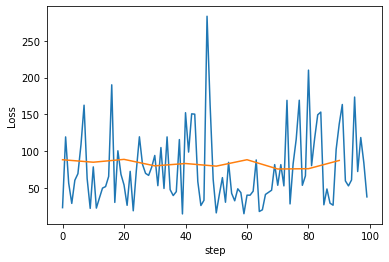

In [12]:
plt.plot(train_steps, train_losses)
plt.plot(dev_steps, dev_losses)
plt.ylabel("Loss")
plt.xlabel("step")